### Predicting Customer Churn in Telco using XGBoost modeling on Virtualized data

### Step 1: Review Use Case

The analytics use case implemented in this notebook is telco churn.We virtualized data sets from DB2Warehouse in Cloud and using the same to build a predictive XGBoost model here.


### Working with Notebooks

If you are new to Notebooks, here's a quick overview of how to work in this environment.

1. The notebook has 2 types of cells - markdown (text) and code. 
2. Each cell with code can be executed independently or together (see options under the Cell menu). When working in this notebook, we will be running one cell at a time because we need to make code changes to some of the cells.
3. To run the cell, position cursor in the code cell and click the Run (arrow) icon. The cell is running when you see the * next to it. Some cells have printable output.
4. Work through this notebook by reading the instructions and executing code cell by cell. Some cells will require modifications before you run them. 

### Step 2: Load data 

In [63]:
# Customer Information
from project_lib import Project
project = Project.access()
USER999_CUSTOMERS_CHURN_INFO_NEW_credentials = project.get_connected_data(name="USER999.CUSTOMERS_CHURN_INFO_NEW")

import jaydebeapi, pandas as pd
USER999_CUSTOMERS_CHURN_INFO_NEW_connection = jaydebeapi.connect('com.ibm.db2.jcc.DB2Driver',
    '{}://{}:{}/{}:user={};password={};'.format('jdbc:db2',
    USER999_CUSTOMERS_CHURN_INFO_NEW_credentials['host'],
    USER999_CUSTOMERS_CHURN_INFO_NEW_credentials['port'],
    USER999_CUSTOMERS_CHURN_INFO_NEW_credentials['database'],
    USER999_CUSTOMERS_CHURN_INFO_NEW_credentials['username'],
    USER999_CUSTOMERS_CHURN_INFO_NEW_credentials['password']))

query = 'SELECT * FROM USER999.CUSTOMERS_CHURN_INFO_NEW'
data = pd.read_sql(query, con=USER999_CUSTOMERS_CHURN_INFO_NEW_connection)
data.head()


,AGE,CAROWNER,CHILDREN,DROPPED,ESTINCOME,GENDER,ID,INTERNATIONAL,LOCAL,LOCALBILLTYPE,LONGDISTANCE,LONGDISTANCEBILLTYPE,PAYMETHOD,PHASE,RATEPLAN,STATUS,USAGE,CHURN
0,47.966667,N,2,0,49745.30,F,3727,0,24,Budget,2,Intnl_discount,CH,Adult,4,M,27,F
1,34.320000,N,2,0,59613.10,M,3728,0,163,Budget,12,Intnl_discount,CC,Adult,1,M,175,T
2,13.860000,N,2,0,88427.00,F,3729,4,43,Budget,22,Standard,CC,Child,3,M,69,F
3,53.693333,N,0,0,89142.70,M,3731,8,5,Budget,3,Intnl_discount,CC,Adult,4,S,16,T
4,25.440000,Y,2,0,9309.57,F,3742,0,99,FreeLocal,8,Standard,CC,Adult,4,M,108,F


If the first step ran successfully (you saw the output), then continue reviewing the notebook and running each code cell step by step. Note that not every cell has a visual output. The cell is still running if you see a * in the brackets next to the cell. 

If the first step didn't finish successfully, check with the instructor. 

### Step 3: Data Exploration 

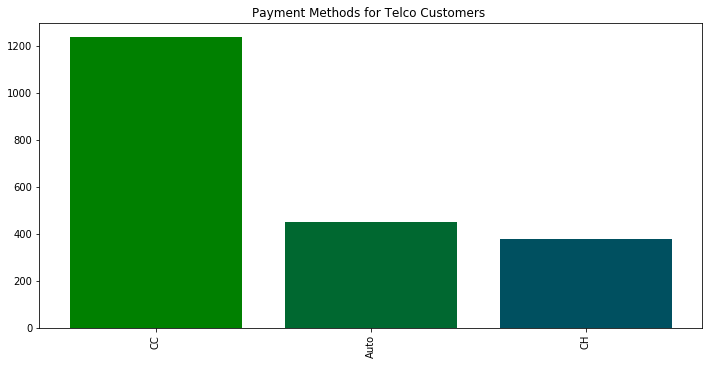

In [91]:
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt

from matplotlib import colors as mcolors
w = Counter(data['PAYMETHOD'].tolist()).most_common(3)
indices = np.arange(len(w))
frequency = []
word=[]
clist = [(0, "green"), (0.125, "blue"), (0.25, "yellow"), (0.5, "blue"), 
         (0.7, "yellow"), (0.75, "purple"), (1, "pink")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)
N = 40
x = np.arange(N).astype(float)
for i in range(len(w)):
  word.append(w[i][0])
  frequency.append(w[i][1])
plt.figure(figsize=(10,5))
plt.bar(indices, frequency,color=rvb(x/N))
plt.xticks(indices, word, rotation='vertical',fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.title('Payment Methods for Telco Customers ', fontsize=12)
plt.show()

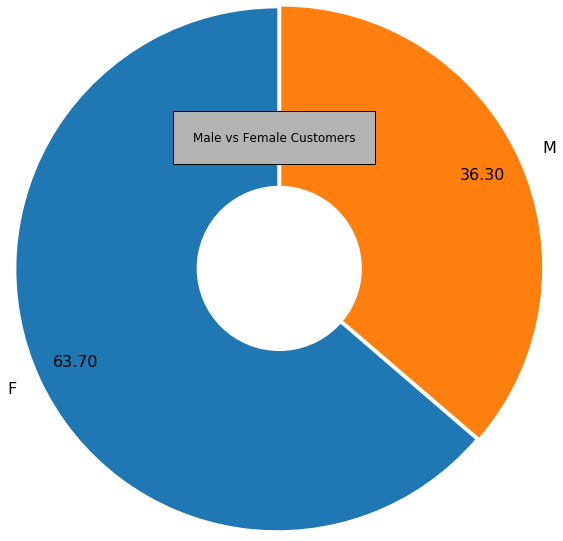

In [108]:
from collections import Counter
from matplotlib import pyplot as plt
import numpy as np
c=Counter(data.GENDER)
histo=c.most_common(5)#n=5
freq={}
for item,count in histo:
    freq[item]=count
explode = (0.025,0.025)
plt.pie([float(v) for v in freq.values()], labels=[(k) for k in freq],autopct='%.2f',startangle=90, pctdistance=0.85, explode = explode,radius=3,textprops={'fontsize': 16})
centre_circle = plt.Circle((0,0),0.95,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
#ax1.axis('equal')  
plt.tight_layout()
plt.suptitle("Male vs Female Customers", bbox={'facecolor':'0.7', 'pad':20})
plt.show()


### Step 4: Encode Categorical Features..
Machine learning models are mathematical models and hence we split categorical variables into a range of categories..and assign boolean values...

In [43]:
#import Label Encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dummy_columns = [] #array for multiple value columns
for column in data.columns:
    if data[column].dtype == object and column != 'ID':
        if data[column].nunique() == 2:
            #apply Label Encoder for binary ones
            data[column] = le.fit_transform(data[column]) 
        else:
            dummy_columns.append(column)
#apply get dummies for selected columns
data = pd.get_dummies(data = data,columns = dummy_columns)

### Step 5: Using the virtualized data to create an XGBoost Model..

In [44]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
#create feature set and labels
X = data.drop(['CHURN','ID'],axis=1)
y = data.CHURN
#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)
#building the model & printing the score
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.99
Accuracy of XGB classifier on test set: 0.98


In [45]:
result=xgb_model.predict(X_test)
result

array([0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1])

In [48]:
from sklearn.metrics  import classification_report
print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        68
           1       0.95      1.00      0.97        36

   micro avg       0.98      0.98      0.98       104
   macro avg       0.97      0.99      0.98       104
weighted avg       0.98      0.98      0.98       104



### Step 6: Feature Importances 

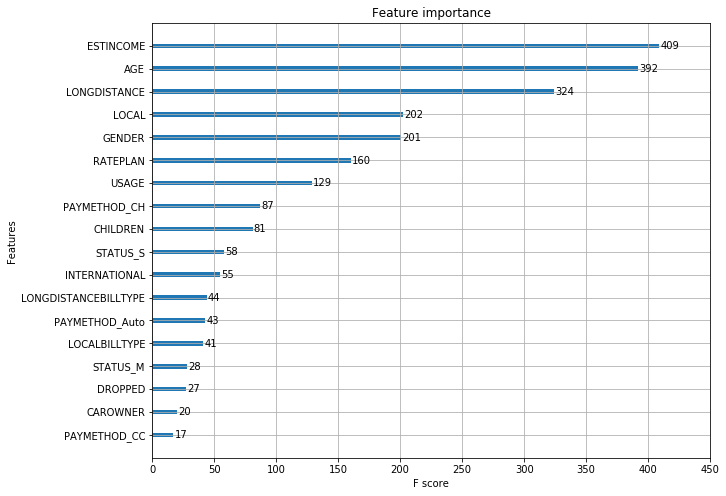

In [90]:
import matplotlib.pyplot as plt
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)





### F Score - This is a metric that simply sums up how many times each feature is split on. It is analogous to the Frequency metric in the R version.https://cran.r-project.org/web/packages/xgboost/xgboost.pdf

It is about as basic a feature importance metric as you can get.

i.e. How many times was this variable split on?

The code for this method shows it is simply adding of the presence of a given feature in all the trees.

[here..https://github.com/dmlc/xgboost/blob/master/python-package/xgboost/core.py#L953][1]

We have finished building and testing a predictive model. The next step is to deploy it for real time scoring. 

# Deploying a ML model ito the CPD platform is beyond the scope of this workshop..


### Summary

You have finished working on this hands-on lab. In this notebook you used virtualized data to create a predictive telco churn XGBoost ML model.